## Setup

In [1]:
!pip list

Package                 Version
----------------------- ------------
asttokens               3.0.0
certifi                 2025.4.26
charset-normalizer      3.4.2
colorama                0.4.6
comm                    0.2.2
contourpy               1.3.2
cycler                  0.12.1
debugpy                 1.8.14
decorator               5.2.1
defusedxml              0.7.1
executing               2.2.0
filelock                3.13.1
filetype                1.2.0
fonttools               4.58.4
fsspec                  2024.6.1
idna                    3.7
ipykernel               6.29.5
ipython                 9.3.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
Jinja2                  3.1.4
jupyter_client          8.6.3
jupyter_core            5.8.1
kiwisolver              1.4.8
MarkupSafe              2.1.5
matplotlib              3.10.3
matplotlib-inline       0.1.7
mpmath                  1.3.0
nest-asyncio            1.6.0
networkx                3.3
numpy                

In [1]:
!nvidia-smi

Sat Jun 14 02:54:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              3W /   45W |     351MiB /   6141MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Fri_Jun_14_16:44:19_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.20
Build cuda_12.6.r12.6/compiler.34431801_0


In [ ]:
# run if first time
# !pip install python-dotenv roboflow opencv-python matplotlib seaborn tqdm supervision

In [4]:
# run if first time
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

In [ ]:
# !pip install ultralytics

In [ ]:
# Import all important libraries
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import ultralytics
import supervision as sv
import random
from collections import Counter
from tqdm import tqdm
from ultralytics import YOLO
from supervision.metrics import MeanAveragePrecision
from dotenv import load_dotenv
from roboflow import Roboflow

%matplotlib inline

In [18]:
ROOT_DIR = os.getcwd() 

In [9]:
ultralytics.checks()

Ultralytics 8.3.154  Python-3.13.1 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Setup complete  (16 CPUs, 15.7 GB RAM, 300.8/456.6 GB disk)


In [8]:
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA Available:  True
CUDA Version: 12.6
PyTorch Version: 2.7.1+cu126
Torchvision Version: 0.22.1+cu126
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


# Dataset Import and Inspection

Dataset Link: https://universe.roboflow.com/tugas-akhir-icad/proyek-akhir-icad

In [ ]:
# Load environment variables
load_dotenv()
api_key = os.getenv("API_KEY")

In [10]:
# Initialize Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("tugas-akhir-icad").project("proyek-akhir-icad")
version = project.version(12)

# Define expected folder name based on format used by Roboflow
dataset_folder = "proyek-akhir-icad-12"

# Check if folder already exists
if not os.path.exists(dataset_folder):
    dataset = version.download("yolov12")
    print(f"Dataset downloaded to: {dataset.location}")
else:
    print(f"Dataset already exists at: {dataset_folder}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to proyek-akhir-icad-12 in yolov12:: 100%|██████████| 4022/4022 [00:01<00:00, 2496.68it/s]

Dataset downloaded to: c:\Users\Artryan Nero Logarta\OneDrive - Mapúa University\MCS663\MCS663_Assignment3\proyek-akhir-icad-12


In [11]:
DATASET_DIR = 'proyek-akhir-icad-12/'
IMAGES_DIR = os.path.join(DATASET_DIR, "train", "images")
LABELS_DIR = os.path.join(DATASET_DIR, "train", "labels")

# List classes
with open(os.path.join(DATASET_DIR, "data.yaml")) as f:
    classes = [line.strip().split(": ")[1].strip("'") for line in f if line.strip().startswith("- ") or ":" in line and "names" in line]

print(f"Classes: {classes}\n")

Classes: ["['ear noise', 'glasses', 'glove', 'helmet', 'shoe', 'vest', 'wearpack']"]



In [12]:
# Data holders
image_sizes = []
bbox_sizes = []
class_counts = Counter()

# Analyze labels
for label_file in tqdm(os.listdir(LABELS_DIR), desc="Analyzing labels"):
    with open(os.path.join(LABELS_DIR, label_file), "r") as f:
        lines = f.readlines()
    if not lines:
        continue
    
    img_file = label_file.replace(".txt", ".jpg")
    img_path = os.path.join(IMAGES_DIR, img_file)
    
    if not os.path.exists(img_path):
        img_path = img_path.replace(".jpg", ".png")
        if not os.path.exists(img_path):
            continue

    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    image_sizes.append((w, h))

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue  # skip malformed lines
        try:
            class_id = int(parts[0])
            x_center, y_center, box_w, box_h = map(float, parts[1:5])
            class_counts[class_id] += 1
            bbox_sizes.append((box_w, box_h))
        except Exception as e:
            print(f"⚠️ Error in {label_file}: {e}")
            continue

Analyzing labels: 100%|██████████| 1404/1404 [00:15<00:00, 93.22it/s]


In [13]:
print(f"Total images: {len(image_sizes)}")
print("First 5 image sizes (W x H):", image_sizes[:5])

print(f"Total bounding boxes: {len(bbox_sizes)}")
print("First 5 normalized bbox sizes (W x H):", bbox_sizes[:5])

Total images: 1404
First 5 image sizes (W x H): [(480, 480), (480, 480), (480, 480), (480, 480), (480, 480)]
Total bounding boxes: 8921
First 5 normalized bbox sizes (W x H): [(0.14479166666666668, 0.12604166666666666), (0.075, 0.09583333333333334), (0.06354166666666666, 0.058333333333333334), (0.05416666666666667, 0.08333333333333333), (0.07083333333333333, 0.03958333333333333)]


In [14]:
print("class_counts keys:", class_counts.keys())
classes = [
    "ear noise",    # class_id = 0
    "glasses",      # class_id = 1
    "glove",        # class_id = 2
    "helmet",       # class_id = 3
    "shoe",         # class_id = 4
    "vest",         # class_id = 5
    "wearpack"      # class_id = 6
]

class_counts keys: dict_keys([3, 2, 4, 6, 5, 1, 0])


In [15]:
assert all(isinstance(k, int) and 0 <= k < len(classes) for k in class_counts.keys()), "Invalid class IDs in class_counts" # Check if assigned IDs are correct

# YOLO

## Training

In [ ]:
model = YOLO("yolo12n.pt")

results = model.train(
    data=os.path.join(DATASET_DIR, "data.yaml"),
    epochs=50,
    imgsz=480,
    device=0,
    plots=True,
    project=ROOT_DIR,
    name="train_yolov12_run1"
    )

100%|██████████| 5.34M/5.34M [00:00<00:00, 26.6MB/s]


Ultralytics 8.3.154  Python-3.13.1 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=proyek-akhir-icad-12/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_yolov12_run1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

100%|██████████| 5.35M/5.35M [00:00<00:00, 45.2MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 559.1127.0 MB/s, size: 38.6 KB)


train: Scanning C:\Users\Artryan Nero Logarta\OneDrive - Mapúa University\MCS663\MCS663_Assignment3\proyek-akhir-icad-12\train\labels... 1404 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1404/1404 [00:00<00:00, 2824.81it/s]


train: New cache created: C:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\proyek-akhir-icad-12\train\labels.cache
WARNING Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 8921. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
val: Fast image access  (ping: 0.10.0 ms, read: 3.00.6 MB/s, size: 32.3 KB)


val: Scanning C:\Users\Artryan Nero Logarta\OneDrive - Mapúa University\MCS663\MCS663_Assignment3\proyek-akhir-icad-12\valid\labels... 400 images, 1 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 746.00it/s]

val: C:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\proyek-akhir-icad-12\valid\images\ppe_0876_jpg.rf.0e29af031da437fbbfa38fda5f85a1b8.jpg: 1 duplicate labels removed
val: New cache created: C:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\proyek-akhir-icad-12\valid\labels.cache
WARNING Box and segment counts should be equal, but got len(segments) = 12, len(boxes) = 3096. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to c:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\train_yolov12_run1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to c:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\train_yolov12_run1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.81G      1.718      3.189       1.41         61        480: 100%|██████████| 88/88 [00:17<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


                   all        400       3096      0.816      0.121      0.217      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.12G      1.702      1.849      1.353        147        480: 100%|██████████| 88/88 [00:14<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.33it/s]

                   all        400       3096       0.54       0.34       0.32      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.13G      1.701      1.721       1.39         78        480: 100%|██████████| 88/88 [00:14<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.08it/s]

                   all        400       3096      0.448      0.377      0.317      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.15G      1.671      1.631      1.371        126        480: 100%|██████████| 88/88 [00:14<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.32it/s]

                   all        400       3096      0.479      0.334      0.311      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.31G      1.646      1.564      1.364        120        480: 100%|██████████| 88/88 [00:14<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.15it/s]

                   all        400       3096      0.514      0.396      0.346      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.33G      1.613        1.5       1.35        156        480: 100%|██████████| 88/88 [00:14<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]

                   all        400       3096      0.521      0.413      0.361      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.34G      1.608      1.487      1.349         78        480: 100%|██████████| 88/88 [00:14<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]

                   all        400       3096       0.57      0.415      0.412        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.36G      1.613      1.404      1.338         95        480: 100%|██████████| 88/88 [00:14<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]

                   all        400       3096      0.471      0.429      0.404      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G      1.574      1.383      1.324        101        480: 100%|██████████| 88/88 [00:13<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]

                   all        400       3096      0.473      0.446      0.431      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.38G      1.577      1.328      1.306        130        480: 100%|██████████| 88/88 [00:14<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]

                   all        400       3096      0.498      0.448      0.429      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.4G      1.542      1.308      1.302        110        480: 100%|██████████| 88/88 [00:14<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]

                   all        400       3096       0.46      0.463      0.447      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.41G      1.541      1.263      1.297        159        480: 100%|██████████| 88/88 [00:13<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.29it/s]

                   all        400       3096      0.533      0.468      0.454      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.43G      1.522      1.267      1.298         86        480: 100%|██████████| 88/88 [00:14<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]

                   all        400       3096      0.556      0.477       0.48      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.45G      1.522      1.235      1.292        111        480: 100%|██████████| 88/88 [00:14<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]

                   all        400       3096      0.497      0.459      0.447      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.46G      1.535       1.23      1.293        184        480: 100%|██████████| 88/88 [00:14<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]

                   all        400       3096      0.484      0.481       0.48      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.47G      1.531      1.213      1.292        116        480: 100%|██████████| 88/88 [00:14<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]

                   all        400       3096      0.494        0.5       0.48      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.49G       1.51      1.195      1.285         80        480: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]

                   all        400       3096      0.492      0.493      0.465      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.5G      1.492      1.164      1.267         60        480: 100%|██████████| 88/88 [00:14<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]

                   all        400       3096      0.553      0.496      0.497      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.52G      1.494      1.154      1.266        110        480: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.33it/s]

                   all        400       3096      0.536      0.493      0.492      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.53G       1.48      1.143      1.259        101        480: 100%|██████████| 88/88 [00:14<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.82it/s]

                   all        400       3096      0.499      0.535       0.49       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.55G      1.474      1.112      1.258        106        480: 100%|██████████| 88/88 [00:13<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]

                   all        400       3096      0.552      0.503      0.504      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.56G      1.473      1.109      1.254         93        480: 100%|██████████| 88/88 [00:13<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]

                   all        400       3096       0.54      0.527      0.514      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.58G      1.449      1.096      1.252        133        480: 100%|██████████| 88/88 [00:13<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]

                   all        400       3096      0.534      0.543      0.524       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.59G      1.456      1.087      1.252        129        480: 100%|██████████| 88/88 [00:14<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]

                   all        400       3096      0.554      0.549      0.529      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.61G      1.451      1.059      1.242         89        480: 100%|██████████| 88/88 [00:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]

                   all        400       3096      0.547      0.546      0.531      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.62G      1.467      1.044       1.24        173        480: 100%|██████████| 88/88 [00:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.76it/s]

                   all        400       3096       0.57      0.531      0.538      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.64G      1.446      1.046      1.238        149        480: 100%|██████████| 88/88 [00:16<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]

                   all        400       3096       0.56      0.541      0.534      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.65G      1.436      1.022      1.235        119        480: 100%|██████████| 88/88 [00:14<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]

                   all        400       3096       0.53      0.548      0.524      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.67G      1.445      1.016      1.228        201        480: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]

                   all        400       3096      0.553       0.55      0.534      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.68G      1.401     0.9951      1.224        131        480: 100%|██████████| 88/88 [00:14<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]

                   all        400       3096      0.557      0.558      0.537      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.7G      1.415     0.9966      1.218         78        480: 100%|██████████| 88/88 [00:14<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]

                   all        400       3096      0.565      0.561      0.548      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.71G      1.406      0.981      1.223        140        480: 100%|██████████| 88/88 [00:14<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.28it/s]

                   all        400       3096      0.575      0.566      0.554      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.73G      1.401     0.9758      1.205        125        480: 100%|██████████| 88/88 [00:14<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]

                   all        400       3096      0.614      0.561       0.57      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.74G      1.388     0.9647      1.206         98        480: 100%|██████████| 88/88 [00:13<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.72it/s]

                   all        400       3096      0.597      0.572      0.576      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.76G       1.39     0.9444      1.204        114        480: 100%|██████████| 88/88 [00:13<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.88it/s]

                   all        400       3096      0.608      0.577      0.577      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.77G      1.371     0.9195      1.205        128        480: 100%|██████████| 88/88 [00:13<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]

                   all        400       3096      0.585      0.572      0.568      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.79G      1.375     0.9159      1.195         80        480: 100%|██████████| 88/88 [00:14<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]

                   all        400       3096      0.598      0.571      0.574      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.8G      1.366     0.9188      1.202         79        480: 100%|██████████| 88/88 [00:13<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]

                   all        400       3096      0.603      0.581      0.578      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.81G      1.357     0.8962      1.191        128        480: 100%|██████████| 88/88 [00:13<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]

                   all        400       3096      0.608      0.585      0.575      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.83G      1.344     0.8863      1.186         99        480: 100%|██████████| 88/88 [00:13<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]

                   all        400       3096      0.616      0.571      0.571      0.301


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.84G      1.338     0.8201      1.192         81        480: 100%|██████████| 88/88 [00:14<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.29it/s]

                   all        400       3096      0.627      0.581      0.594      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.86G      1.321     0.7996      1.181         47        480: 100%|██████████| 88/88 [00:13<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.81it/s]

                   all        400       3096      0.626      0.555      0.565      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.87G      1.318     0.7788      1.178        101        480: 100%|██████████| 88/88 [00:13<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.86it/s]

                   all        400       3096      0.629       0.59       0.59      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.89G      1.298     0.7562      1.169         79        480: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.85it/s]

                   all        400       3096      0.624      0.569       0.58      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.9G      1.286     0.7445      1.159         83        480: 100%|██████████| 88/88 [00:13<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.81it/s]

                   all        400       3096       0.62      0.581      0.578      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.92G      1.272     0.7322      1.156         81        480: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.84it/s]

                   all        400       3096       0.61      0.583      0.576      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.93G      1.265     0.7242      1.147         53        480: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.89it/s]

                   all        400       3096      0.649      0.577      0.585      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.95G      1.259      0.715      1.149         86        480: 100%|██████████| 88/88 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]

                   all        400       3096      0.653      0.563      0.583      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.96G      1.255     0.7136       1.14         76        480: 100%|██████████| 88/88 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.61it/s]

                   all        400       3096      0.669      0.566      0.591      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.98G      1.247     0.7015      1.138         54        480: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]

                   all        400       3096      0.648      0.587      0.592      0.315



50 epochs completed in 0.240 hours.
Optimizer stripped from c:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\train_yolov12_run1\weights\last.pt, 5.5MB
Optimizer stripped from c:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\train_yolov12_run1\weights\best.pt, 5.5MB

Validating c:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\train_yolov12_run1\weights\best.pt...
Ultralytics 8.3.154  Python-3.13.1 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv12n summary (fused): 159 layers, 2,558,093 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


                   all        400       3096      0.632       0.59      0.591      0.316
             ear noise         82        102      0.439      0.412      0.416       0.22
               glasses        157        224      0.668      0.576       0.59      0.275
                 glove        253        618      0.573      0.409      0.419      0.173
                helmet        389       1070      0.868      0.897      0.914      0.508
                  shoe        107        344      0.534      0.424      0.411      0.192
                  vest        176        384      0.791      0.819      0.843      0.539
              wearpack        191        354      0.549      0.595      0.544      0.303
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to c:\Users\Artryan Nero Logarta\OneDrive - Mapa University\MCS663\MCS663_Assignment3\train_yolov12_run1


In [21]:
latest_run_path = os.path.join(ROOT_DIR, "train_yolov12_run1")

## Evaluation

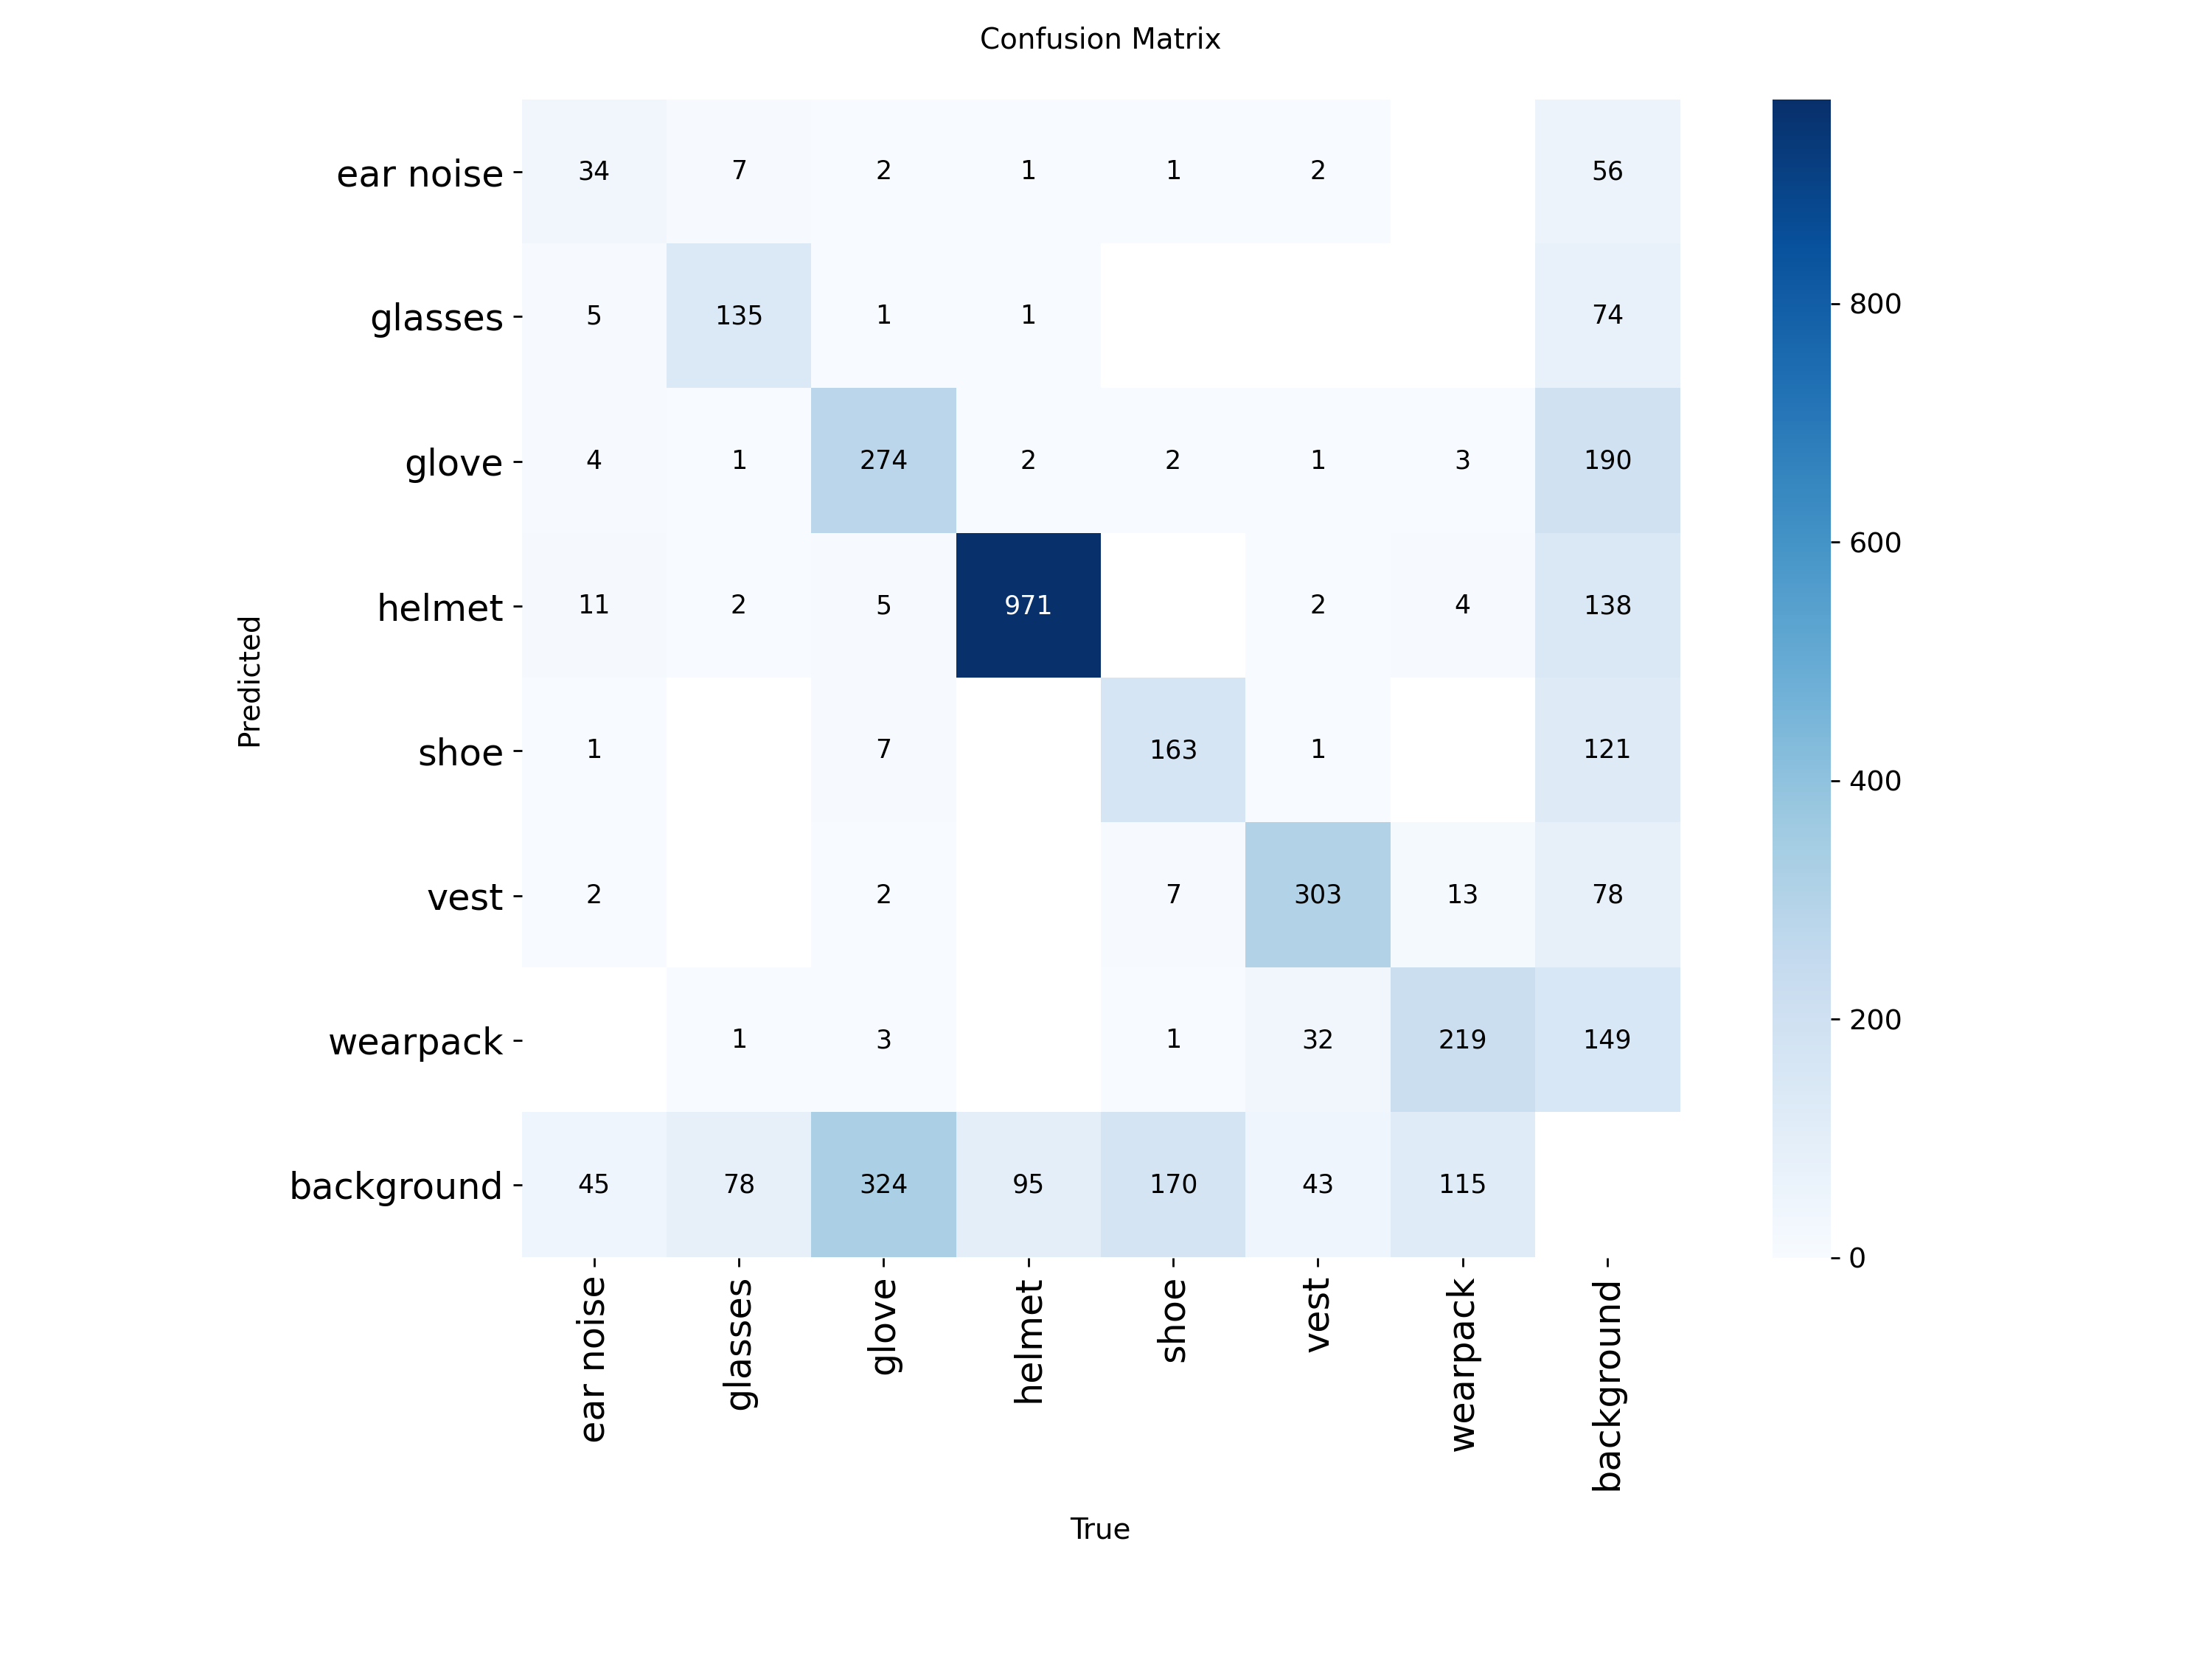

In [22]:
from IPython.display import Image

Image(filename=os.path.join(latest_run_path, 'confusion_matrix.png'), width=1000)

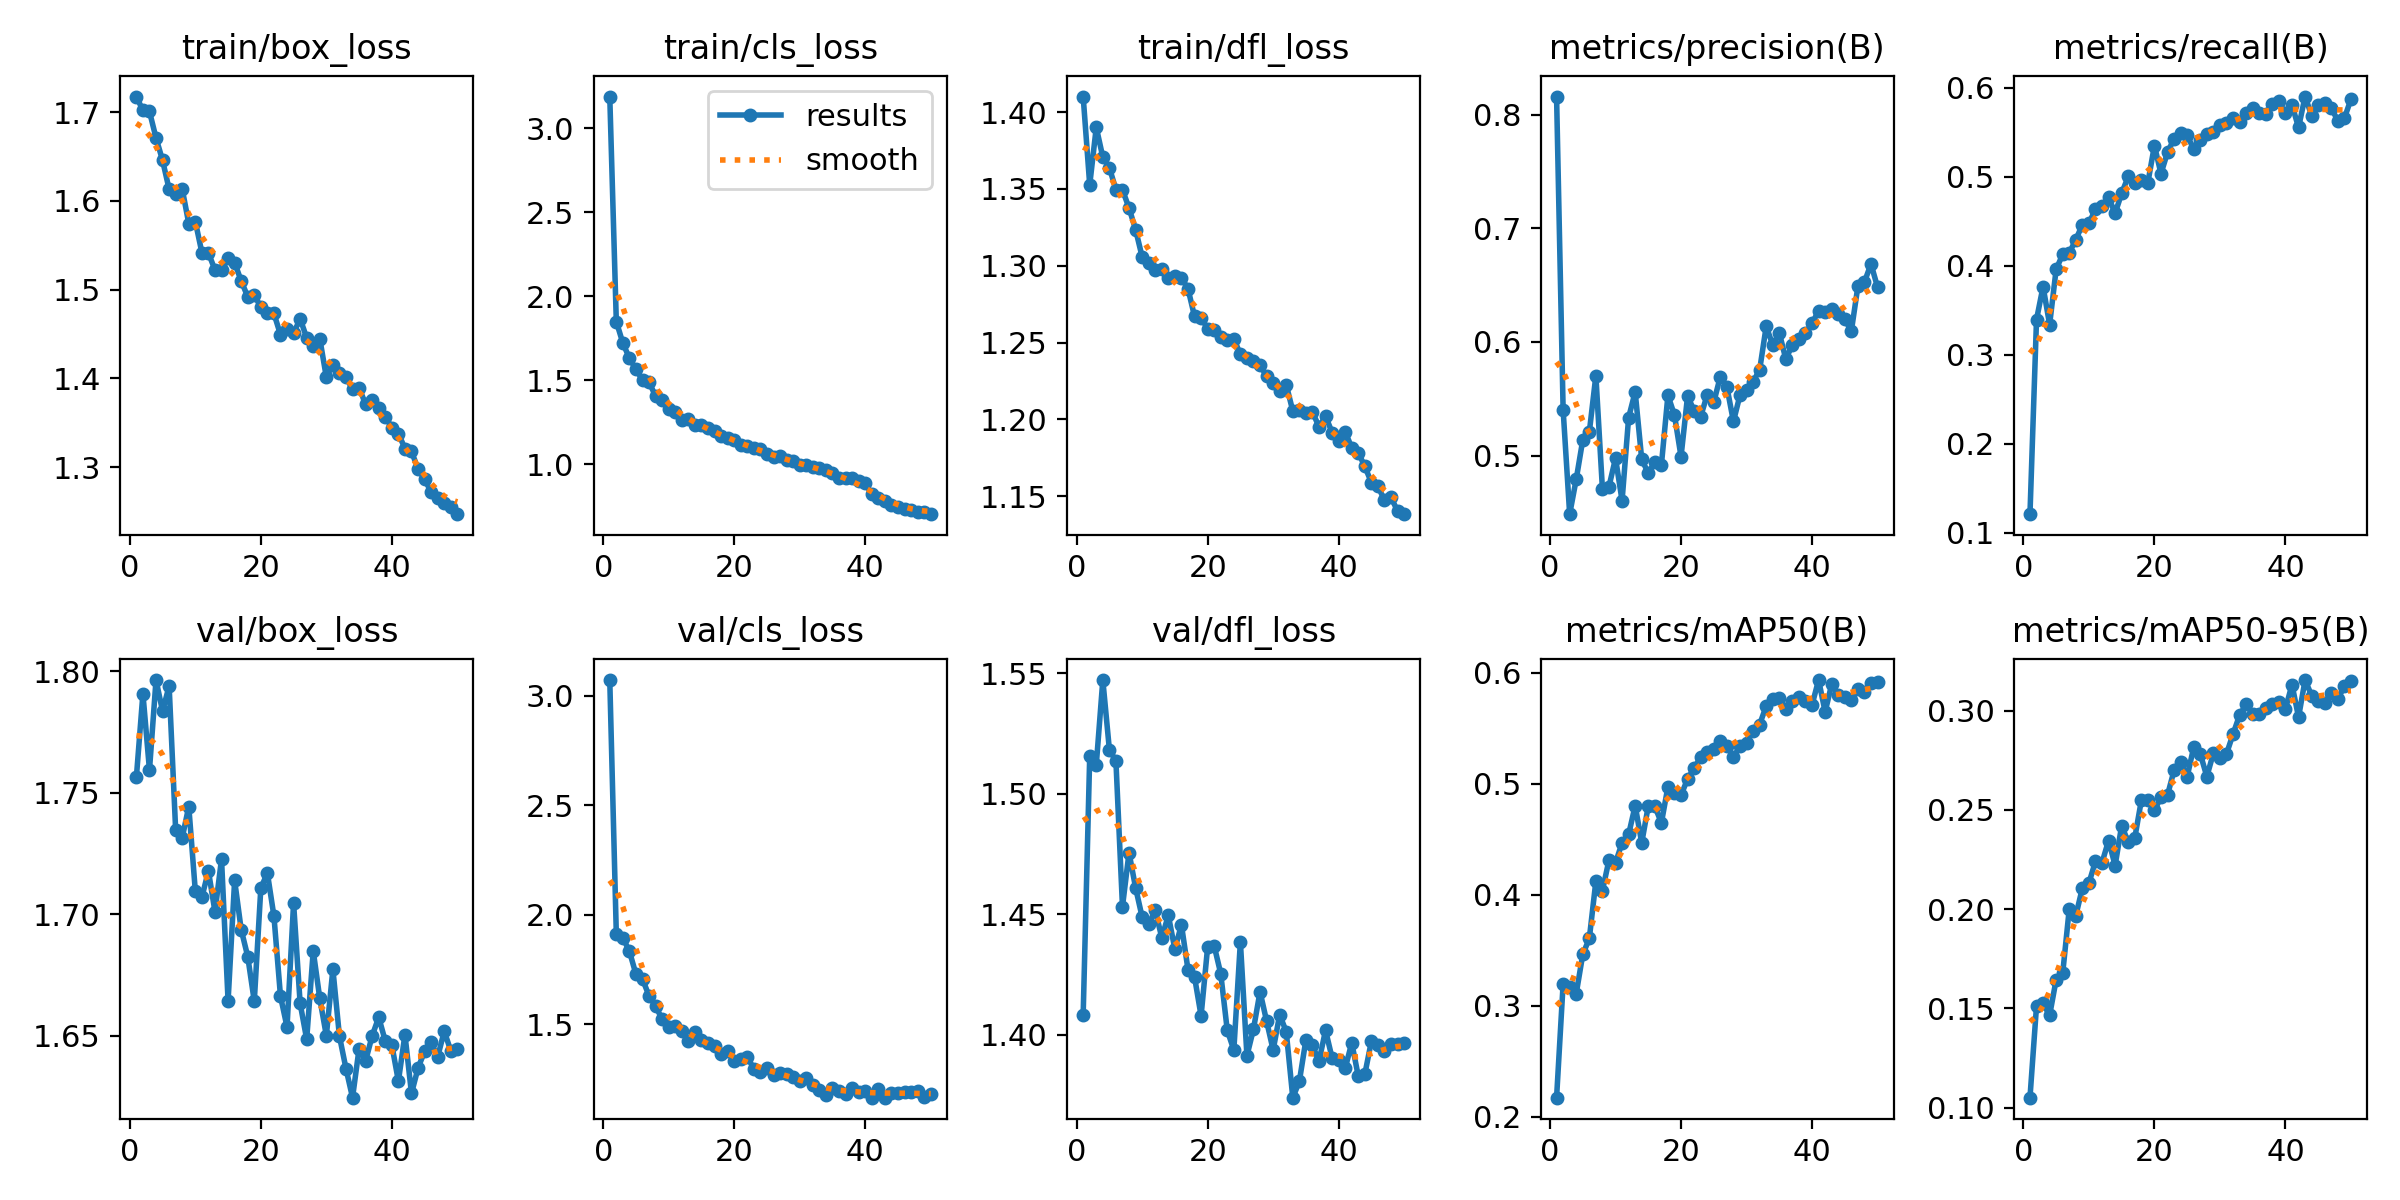

In [23]:
from IPython.display import Image

Image(filename=os.path.join(latest_run_path, 'results.png'), width=1000)

In [ ]:
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['ear noise', 'glasses', 'glove', 'helmet', 'shoe', 'vest', 'wearpack']

In [28]:
model = YOLO(os.path.join(latest_run_path, 'weights/best.pt'))

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [29]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.25073988686901283
mAP 50 0.4619510675824327
mAP 75 0.24478473466308287


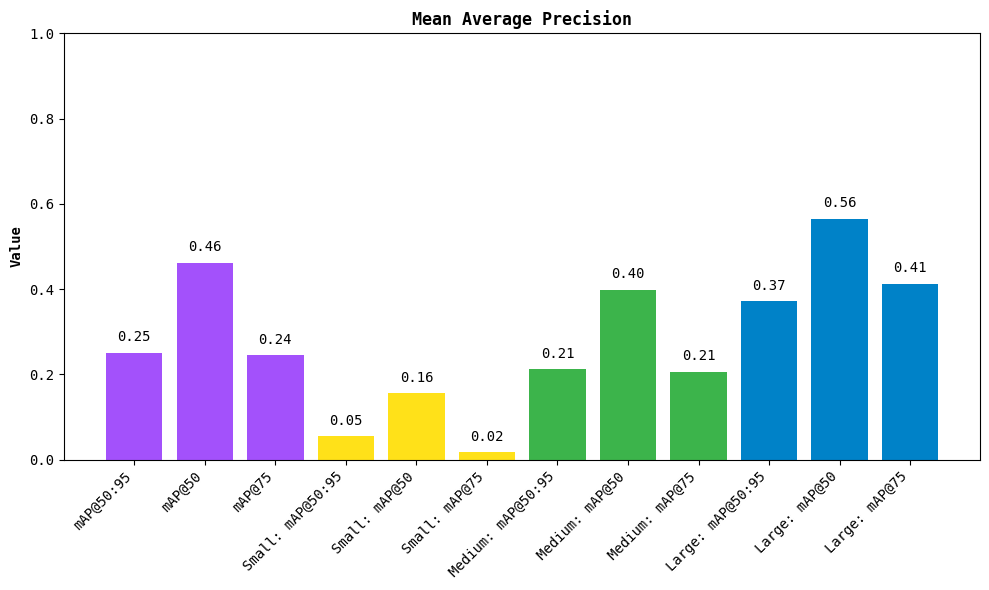

In [35]:
map.plot()

## Inference with fine-tuned YOLOv12 model

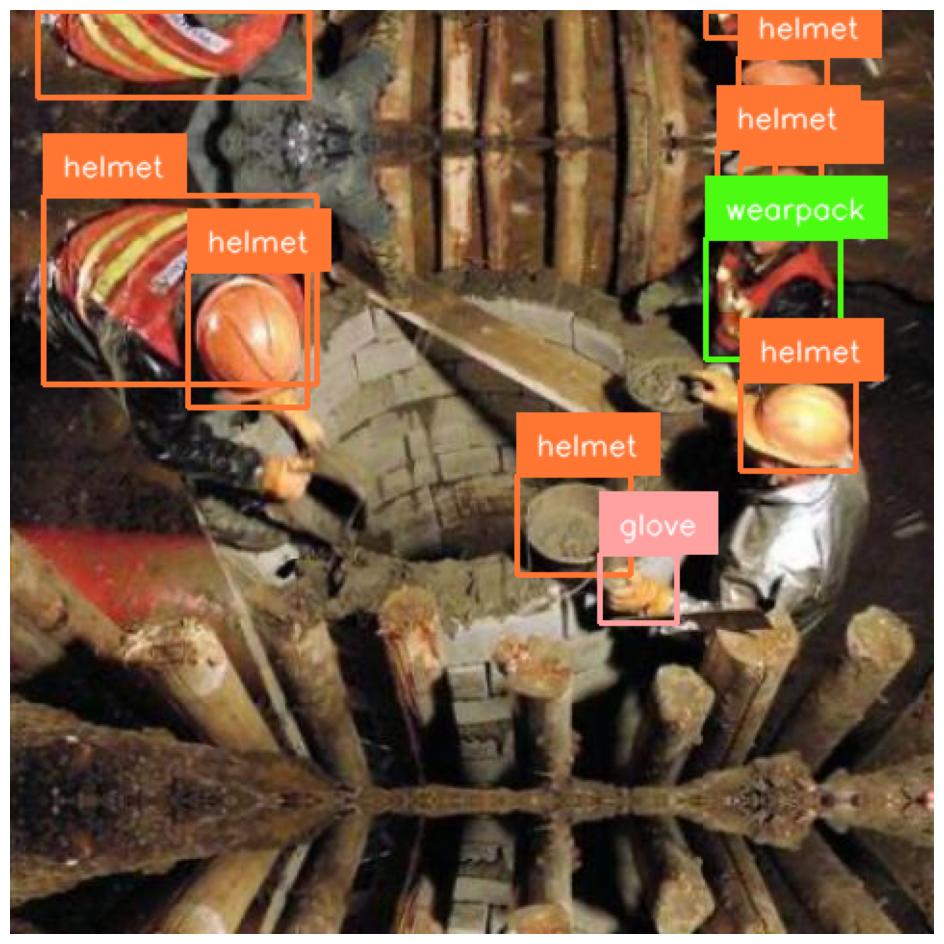

In [ ]:
i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)